In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models

In [2]:
import time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
augmentation = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

In [5]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=T.ToTensor())
mnist_train_aug = torchvision.datasets.MNIST(".", train=True, download=True, transform=lambda i: augmentation(i))
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=T.ToTensor())

In [6]:
batch_size = 128
train_cutoff = int(len(mnist_train) * 0.9)
train_data = D.DataLoader(D.Subset(mnist_train, range(train_cutoff)), batch_size=batch_size, num_workers=4)
train_data_aug = D.DataLoader(D.Subset(mnist_train_aug, range(train_cutoff)), batch_size=batch_size, num_workers=12)
val_data = D.DataLoader(D.Subset(mnist_train, range(train_cutoff, len(mnist_train))), batch_size=batch_size, num_workers=4)
test_data = D.DataLoader(mnist_test, batch_size=batch_size, num_workers=4)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
def train(dataloader, model, optimizer):
    losses = []
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        pred = model.forward(x)
        loss = model.loss(pred, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return torch.tensor(losses).mean().item()

In [9]:
@torch.no_grad()
def validate(dataloader, model):
    model.eval()
    loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss += model.loss(pred, y).item()
    return loss / len(dataloader)

In [10]:
@torch.no_grad()
def test(dataloader, model):
    model.eval()
    correct = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= len(dataloader) * batch_size
    print(f"Test accuracy: {(100*correct):>0.1f}%")

In [11]:
def trainloop(model, epochs=5, optimizer=torch.optim.AdamW, verbose=False, **optargs):
    optimizer = optimizer(model.parameters(), **optargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    start = time.time()
    train_losses, val_losses = [], []
    for e in range(epochs):
        epoch_start = time.time()
        train_loss = train(train_data_aug, model, optimizer)
        val_loss = validate(val_data, model)
        if verbose:
            print(f"Epoch {e}: {time.time()-epoch_start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}, lr {optimizer.param_groups[0]['lr']}")
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    nparams = sum(p.numel() for p in model.parameters())
    print(f"Train [{nparams/1e6:.3f}M params]: {epochs} epochs took {time.time()-start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

In [12]:
def errorplot(dataset, model, count=5):
    plt.figure()
    f, axarr = plt.subplots(1, count)
    for x, y in dataset:
        pi, pv = model.predict(x[None,None:].to(device))
        if pi.item() != y:
            ax = axarr[count-1]
            ax.set_title(f"pred {pi.item()} gt {y}\nprob {pv.item():.2f}")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(x[0], cmap="binary")
            count -= 1
            if count == 0:
                break

In [139]:
class DigitsFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        self.loss = nn.CrossEntropyLoss()
        
    # image => logit
    def forward(self, x):
        y = self.layers(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

Train [0.67M params]: 50 epochs took 114.16 sec, train loss 0.031799, val loss 0.029352


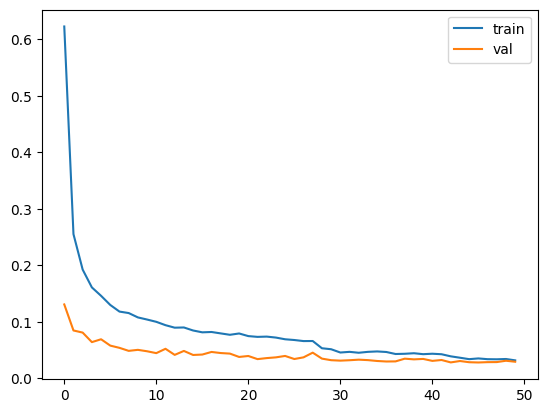

In [140]:
# 3 fully connected layers; reaches 0.029 loss in 50 epochs (2 minutes), 98.2% accuracy
torch.manual_seed(42)
mfc = DigitsFC().to(device)
trainloop(mfc, epochs=50, weight_decay=0.01)

In [155]:
class DigitsLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), # 1x28x28 => 6x28x28
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # 6x28x28 => 6x14x14
            nn.ReLU(),
            nn.Conv2d(6, 16, kernel_size=5), # 6x14x14 => 16x10x10
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # 16x10x10 => 16x5x5
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10))
        self.loss = nn.CrossEntropyLoss()
        
    # image => logit
    def forward(self, x):
        y = self.layers(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

Train [0.062M params]: 50 epochs took 137.14 sec, train loss 0.026267, val loss 0.026350


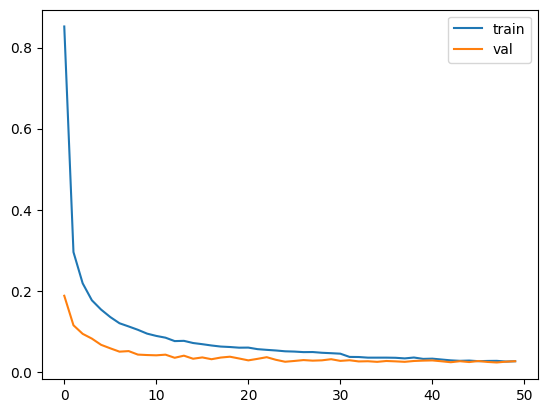

In [200]:
# LeNet'98; reaches 0.026 loss in 50 epochs (2 minutes), 98.3% accuracy
torch.manual_seed(42)
mln = DigitsLeNet().to(device)
trainloop(mln, epochs=50, weight_decay=0.01)

In [129]:
class DigitsTN(nn.Module):
    def __init__(self, net, finetune=False):
        super().__init__()
        self.net = net
        for p in self.net.parameters():
            p.requires_grad = finetune
        self.net.classifier = nn.Sequential(
            nn.Linear(self.net.classifier[0].in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
        self.loss = nn.CrossEntropyLoss()
    
    # mnist image => imagenet image
    def xform(self, x):
        assert(x.shape[1] == 1)
        x = x.repeat(1, 3, 1, 1)
        x = T.functional.resize(x, [64, 64])
        x = T.functional.pad(x, padding=(224-64)//2)
        return x
    
    # image => logit
    def forward(self, x):
        x = self.xform(x)
        y = self.net(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

Train [12.433M params]: 10 epochs took 537.32 sec, train loss 0.066222, val loss 0.033030


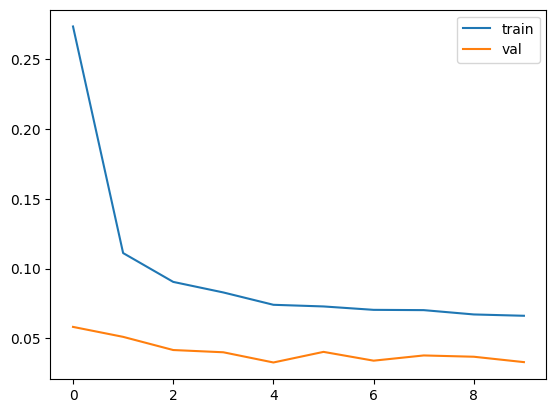

In [139]:
# Pretrained VGG11, with FC layer replaced and retrained: reaches 0.033 loss in 10 epochs (10 minutes), 97.7% accuracy
torch.manual_seed(42)
mtn = DigitsTN(torchvision.models.vgg11(weights="DEFAULT")).to(device)
trainloop(mtn, epochs=10)

In [137]:
class DigitsCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            # 1x28x28 => 8x28x28
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8x14x14 => 8x16x16
            nn.ZeroPad2d(1),
            # 8x16x16 => 16x8x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 16x8x8 => 32x4x4
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32x4x4 = 512
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
        self.loss = nn.CrossEntropyLoss()
        
    # image => logit
    def forward(self, x):
        y = self.layers(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

Train [0.164M params]: 50 epochs took 137.28 sec, train loss 0.009603, val loss 0.017390


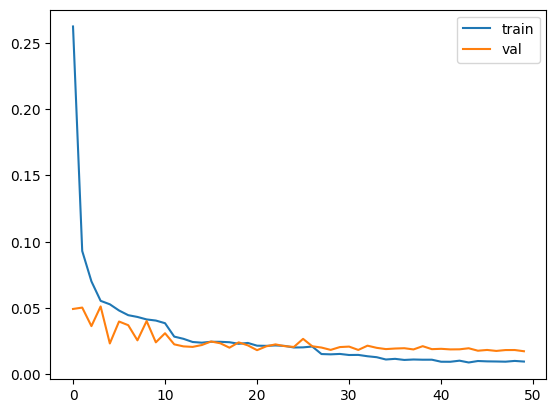

In [138]:
# VGG-inspired 3-level reduction + 2 fully connected layers; reaches 0.017 loss in 50 epochs (7 minutes), 98.6% accuracy
torch.manual_seed(42)
mcn = DigitsCNN().to(device)
trainloop(mcn, epochs=50, weight_decay=0.01)

<Figure size 640x480 with 0 Axes>

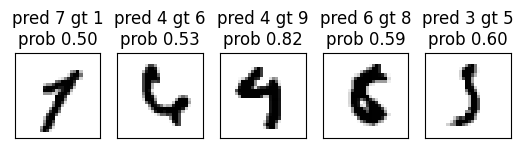

In [140]:
errorplot(mnist_train, mcn)

In [141]:
test(test_data, mcn)

Test accuracy: 98.6%
